<a href="https://colab.research.google.com/github/sjain2025/Wikipedia-PageRank-HITS/blob/main/Wikipedia_PageRank_HITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mapping Influential Articles in Local Wikipedia Networks via Personalized PageRank and Hyperlink-Induced Topic Search**
## **Soham Jain & Saye Karthikeyan**

## Setup and Graph Initialization

In [104]:
!pip install wikipedia-api networkx matplotlib numpy requests wikipedia

In [105]:
import wikipediaapi
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import time
import requests
import json
import random
# Included all necessary libraries. NetworkX used for graph creation. WikiAPI
# used for scraping necessary data. Matplotlib and Numpy for calculation/visualization

# Initialize Wikipedia API
wiki_wiki = wikipediaapi.Wikipedia(
    user_agent='WikipediaGraphAnalysis/1.0 (https://example.com)',
    language='en',
    extract_format=wikipediaapi.ExtractFormat.WIKI
)

In [106]:
def search_wikipedia_first_result(search_term):
    '''
      Searched for the very first result for the search term.
      Doing a search instead of direct lookup since syntactically
      whatever we enter as a seed might not be the exact page name,
      so this helps us circumvent that.
    '''
    try:
        url = "https://en.wikipedia.org/w/api.php"
        params = {
            "action": "query",
            "list": "search",
            "srsearch": search_term,
            "srlimit": 1,
            "format": "json",
            "srnamespace": 0
        }

        headers = {
            'User-Agent': 'WikipediaGraphAnalysis/1.0 (https://example.com; contact@example.com)'
        }

        response = requests.get(url, params=params, timeout=15, headers=headers)

        # Check response status
        if response.status_code != 200:
            print(f"HTTP {response.status_code} for '{search_term}'")
            return None

        # Parsing JSON
        try:
            data = response.json()
        except ValueError as e:
            print(f"Response preview")
            return None

        if "query" in data and "search" in data["query"] and len(data["query"]["search"]) > 0:
            title = data["query"]["search"][0]["title"]
            page = wiki_wiki.page(title)
            if page.exists():
                return title
        return None
    except Exception as e:
        print(f"Error searching")
        return None

    return None

def get_wiki_links(page_title, max_links=2):
    '''
        Get internal Wiki links from a page.
        Based on parameters that we tuned, especially
        the maximum number of links, which is discussed
        more thoroughly in the report. Filtering for actual
        links and not files or categories.

        Randomized since we initially found that
        our links were returned in alphabetical order
        in the event of a tie between pagerank scores.
    '''
    try:
        page = wiki_wiki.page(page_title)

        # Collect all valid links
        all_links = []
        for link_title in page.links.keys():
            if link_title and not link_title.startswith('Category:') and not link_title.startswith('File:') and not link_title.startswith('Template:'):
                all_links.append(link_title)

        # Randomize to avoid uniformity, then returning up until the maximum amount of links
        random.shuffle(all_links)
        return all_links[:max_links]
    except Exception as e:
        print(f"Error getting links")
        return []

In [107]:
def build_wikipedia_graph(seed_terms, max_depth=2, max_links_per_page=2, max_total_pages=200):
    '''
        Build a directed graph from Wikipedia pages starting with seed terms. (u, w) and (w, u) valid edges in this graph.
        - seed_terms: List of search terms
        - max_depth: How many levels of links to follow
        - max_links_per_page: Maximum links to extract per page
        - max_total_pages: Maximum total pages to include in graph
    '''
    G = nx.DiGraph()
    # BFS Mark set to check membership easily
    visited = set()
    seed_pages = []

    for term in seed_terms:
        page_title = search_wikipedia_first_result(term)
        if page_title:
            print(f"Found: '{term}' -> '{page_title}'")
            seed_pages.append(page_title)
            visited.add(page_title)
            G.add_node(page_title, is_seed=True)
        else:
            print(f"No result found for '{term}'")

    # Running BFS
    queue = deque([(page, 0) for page in seed_pages])  # (page_title, depth)

    while queue and len(visited) < max_total_pages:
        current_page, depth = queue.popleft()

        if depth >= max_depth:
            continue

        # Stop if we have reached the maximum number of pages
        if len(visited) >= max_total_pages:
            break

        # Get links from current page - use max_links_per_page parameter
        links = get_wiki_links(current_page, max_links=max_links_per_page)

        for link in links:
            # Stop adding nodes if we've reached the limit
            if len(visited) >= max_total_pages:
                break

            if link != current_page:
                if link not in visited and len(visited) < max_total_pages:
                    # Can add new node if the link is not already in visited
                    visited.add(link)
                    G.add_node(link, is_seed=False)
                    G.add_edge(current_page, link)

                    # Add to queue if we haven't reached max depth
                    if depth + 1 < max_depth:
                        queue.append((link, depth + 1))

        time.sleep(0.1) # To avoid timeouts from excessive API calls

    return G

## Personalized PageRank

In [108]:
def personalized_pagerank(G, seed_pages, damping=0.85, max_iter=100, tol=1e-6):
    '''
    Runs Personalized PageRank

    Using power iteration to calculate the Pagerank vector, within a tolerance of 1e-6.

    Only addition to Power iteration is that we restart at seed pages, making algorithm focus on nodes relevant to the seed topics.
    '''

    nodes = list(G.nodes())
    n = len(nodes)

    if n == 0:
        return {}

    # Create node-to-index mapping, since networkX doesn't enumerate nodes
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    idx_to_node = {i: node for i, node in enumerate(nodes)}

    # Build adjacency matrix A (for directed graph)
    # A[i,j] = 1 if there's a directed edge FROM node i TO node j
    A = np.zeros((n, n))
    for i, node in enumerate(nodes):
        # For directed graph: check outgoing edges (successors)
        for neighbor in G.successors(node):
            j = node_to_idx[neighbor]
            A[i, j] = 1.0  # Edge from node i to node j

    # Making markov matrix out of adjacency matrix A
    # Compute column sums (out-degrees)
    col_sums = np.sum(A, axis=0)

    # Build transition matrix M: handle dangling nodes (columns with sum 0)
    # For columns with sum > 0: M[i,j] = A[i,j] / col_sum[j]
    # For columns with sum = 0 (dangling nodes): M[i,j] = 1/n (uniform distribution)
    M = np.zeros((n, n))
    for j in range(n):
        if col_sums[j] > 0:
            M[:, j] = A[:, j] / col_sums[j]
        else:
            # Dangling node: replace with uniform distribution 1/n
            M[:, j] = 1.0 / n

    # Create personalization vector v (teleportation vector)
    v = np.zeros(n)
    seed_weight = 1.0 / len(seed_pages)
    for node in nodes:
        if node in seed_pages:
            # Giving equal weight to seed pages, nonzero only for seeds
            v[node_to_idx[node]] = seed_weight
        # Normalize to ensure it sums to exactly 1
    v = v / np.sum(v) if np.sum(v) > 0 else np.ones(n) / n

    # Initialize PageRank vector
    pr = np.ones(n) / n

    # Power method
    for iteration in range(max_iter):
        # Compute new PageRank
        pr_new = (1 - damping) * v + damping * (M @ pr)

        # Check if it is within tolerance
        diff = np.sum(np.abs(pr_new - pr))
        pr = pr_new


        if diff < tol:
            break

    # Normalize entries
    pr = pr / np.sum(pr) if np.sum(pr) > 0 else pr

    # Convert back to dictionary
    pagerank_scores = {idx_to_node[i]: float(pr[i]) for i in range(n)}

    return pagerank_scores

In [109]:
def visualize_graph(G, pagerank_scores, seed_pages, top_n=10):
    '''
        Visualize the graph with node sizes and colors based on PageRank scores.
    '''
    if G.number_of_nodes() == 0:
        print("Graph is empty, cannot visualize.")
        return

    plt.figure(figsize=(16, 12))

    # Get top influential nodes - sort by score (descending)
    def sort_key(item):
        node, score = item
        # tie breaker for same scores
        return (-score, hash(node) % 1000000)

    sorted_nodes = sorted(pagerank_scores.items(), key=sort_key)
    top_nodes = [node for node, _ in sorted_nodes[:top_n]]

    node_sizes = []
    node_colors = []
    node_labels = {}

    for node in G.nodes():
        # Node size based on PageRank score
        size = pagerank_scores.get(node, 0) * 10000
        node_sizes.append(max(size, 50))  # Minimum size

        # Color: red for seeds, orange for top influential, blue for others
        if node in seed_pages:
            node_colors.append('red')
        elif node in top_nodes:
            node_colors.append('orange')
        else:
            node_colors.append('lightblue')

        # Only label seed pages and top influential nodes
        if node in seed_pages or node in top_nodes:
            # Truncate long titles
            label = node[:30] + '...' if len(node) > 30 else node
            node_labels[node] = label

    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, arrows=True, arrowsize=10, arrowstyle='->')
    nx.draw_networkx_labels(G, pos, node_labels, font_size=8, font_weight='bold')

    plt.title('Wikipedia Graph with Personalized PageRank\n(Red=Seed, Orange=Top Influential, Blue=Others)',
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print top influential nodes
    print(f"\nTop {top_n} Most Influential Pages (by Personalized PageRank):")
    print("-" * 70)
    prev_score = None
    for i, (node, score) in enumerate(sorted_nodes[:top_n], 1):
        # Show if score is same as previous (tied)
        print(f"{i:2d}. {node[:50]:50s} (Score: {score:.8f})")
        prev_score = score

## Hyperlink-Induced Topic Search (HITS)

In [110]:
def hits(G, max_iter=100, tol=1e-6):
    '''
    Runs Hyperlink-Induced Topic Search (HITS)
    Updates authority and hub vectors to convergence until tolerance of 1e-6 is reached:
    a_{k+1} = A^T * h_k
    h_{k+1} = A * a_{k+1}
    a_{k+1} = a_{k+1} / ||a_{k+1}||_2
    h_{k+1} = h_{k+1} / ||h_{k+1}||_2
    '''
    nodes = list(G.nodes())
    n = len(nodes)

    if n == 0:
        return {}, {}

    # Create node-to-index mapping, since networkX doesn't enumerate nodes
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    idx_to_node = {i: node for i, node in enumerate(nodes)}

    # Build adjacency matrix A (for directed graph)
    # A[i,j] = 1 if there's a directed edge FROM node i TO node j
    A = np.zeros((n, n))
    for i, node in enumerate(nodes):
        # For directed graph: check outgoing edges (successors)
        for neighbor in G.neighbors(node):
            j = node_to_idx[neighbor]
            A[i, j] = 1.0 # Edge from node i to node j

    # Initialize authority vector and hub vector
    hub = np.random.rand(n) * 1e-6
    auth = np.random.rand(n) * 1e-6

    # Iterative updates of a and h
    for iteration in range(max_iter):
        # Compute new authority vector: a_{k+1} = A^T * h_k
        new_auth = A.T @ hub
        # Compute new hub vector: h_{k+1} = A * a_{k+1}
        new_hub = A @ new_auth

        # Normalize authority and hub vectors
        a_norm = np.linalg.norm(new_auth, 2)
        h_norm = np.linalg.norm(new_hub, 2)
        if a_norm == 0 or h_norm == 0:
          break
        new_auth = new_auth / a_norm
        new_hub = new_hub / h_norm

        # Check if it is within the tolerance
        diff_a = np.linalg.norm(new_auth - auth, 2)
        diff_h = np.linalg.norm(new_hub - hub, 2)
        auth = new_auth
        hub = new_hub
        if diff_a < tol and diff_h < tol:
          break

    # Convert back to dictionary
    authority_scores = {idx_to_node[i]: float(auth[i]) for i in range(n)}
    hub_scores = {idx_to_node[i]: float(hub[i]) for i in range(n)}

    return authority_scores, hub_scores

In [111]:
def visualize_hits(G, authority_scores, hub_scores, seed_pages, top_n=10):
    '''
    Visualize the graph with node sizes and colors based on HITS authority and hub scores.
    '''
    if G.number_of_nodes() == 0:
        return

    # Get top influential nodes - sort by score (descending)
    def sort_key(item):
        node, score = item
        # tie breaker for same scores
        return (-score, hash(node) % 1000000)

    sorted_auth = sorted(authority_scores.items(), key=sort_key)
    sorted_hub = sorted(hub_scores.items(), key=sort_key)
    top_auth = [node for node, _ in sorted_auth[:top_n]]
    top_hub = [node for node, _ in sorted_hub[:top_n]]

    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

    # Function to draw the graph for each type of score
    def draw_graph(title, score_map, top_nodes):
        plt.figure(figsize=(16, 12))

        node_sizes = []
        node_colors = []
        node_labels = {}

        for node in G.nodes():
            # Node size based on HITS authority or hub score
            size = score_map.get(node, 0) * 10000
            node_sizes.append(max(size, 50)) # Minimum size

            # Color: red for seeds, orange for top influential, blue for others
            if node in seed_pages:
                node_colors.append('red')
            elif node in top_nodes:
                node_colors.append('orange')
            else:
                node_colors.append('lightblue')

            # Only label seed pages and top influential nodes
            if node in seed_pages or node in top_nodes:
                # Truncate long titles
                lbl = node[:30] + '...' if len(node) > 30 else node
                node_labels[node] = lbl

        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
        nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, arrows=True, arrowsize=10, arrowstyle='->')
        nx.draw_networkx_labels(G, pos, node_labels, font_size=8, font_weight='bold')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Draws graph for authority and hub scores
    draw_graph("Wikipedia Graph with HITS Authority Scores\n(Red=Seed, Orange=Top Influential, Blue=Others)", authority_scores, top_auth)
    draw_graph("Wikipedia Graph with HITS Hub Scores\n(Red=Seed, Orange=Top Influential, Blue=Others)", hub_scores, top_hub)

    # Print top influential nodes for authorities
    print(f"\nTop {top_n} Most Influential Pages (by HITS Authority Scores):")
    print("-" * 70)
    prev_score = None
    for i, (node, score) in enumerate(sorted_auth[:top_n], 1):
      # Show if score is same as previous (tied)
      print(f"{i:2d}. {node[:50]:50s} (Score: {score:.8f})")
      prev_score = score

    # Print top influential nodes for hubs
    print(f"\nTop {top_n} Most Influential Pages (by HITS Hub Scores):")
    print("-" * 70)
    prev_score = None
    for i, (node, score) in enumerate(sorted_hub[:top_n], 1):
      # Show if score is same as previous (tied)
      print(f"{i:2d}. {node[:50]:50s} (Score: {score:.8f})")
      prev_score = score

## Testing

In [112]:
# Input params
seed_terms = [
    "planets",
    "supernova",
    "hubble"
]

# Build the graph
G = build_wikipedia_graph(
    seed_terms,
    max_depth=2,
    max_links_per_page=2,
    max_total_pages=200
)

# Initialize pages for seed articles
seed_pages = [node for node, attrs in G.nodes(data=True) if attrs.get('is_seed', False)]

Found: 'planets' -> 'Planet'
Found: 'supernova' -> 'Supernova'
Found: 'hubble' -> 'Hubble Space Telescope'


PageRank

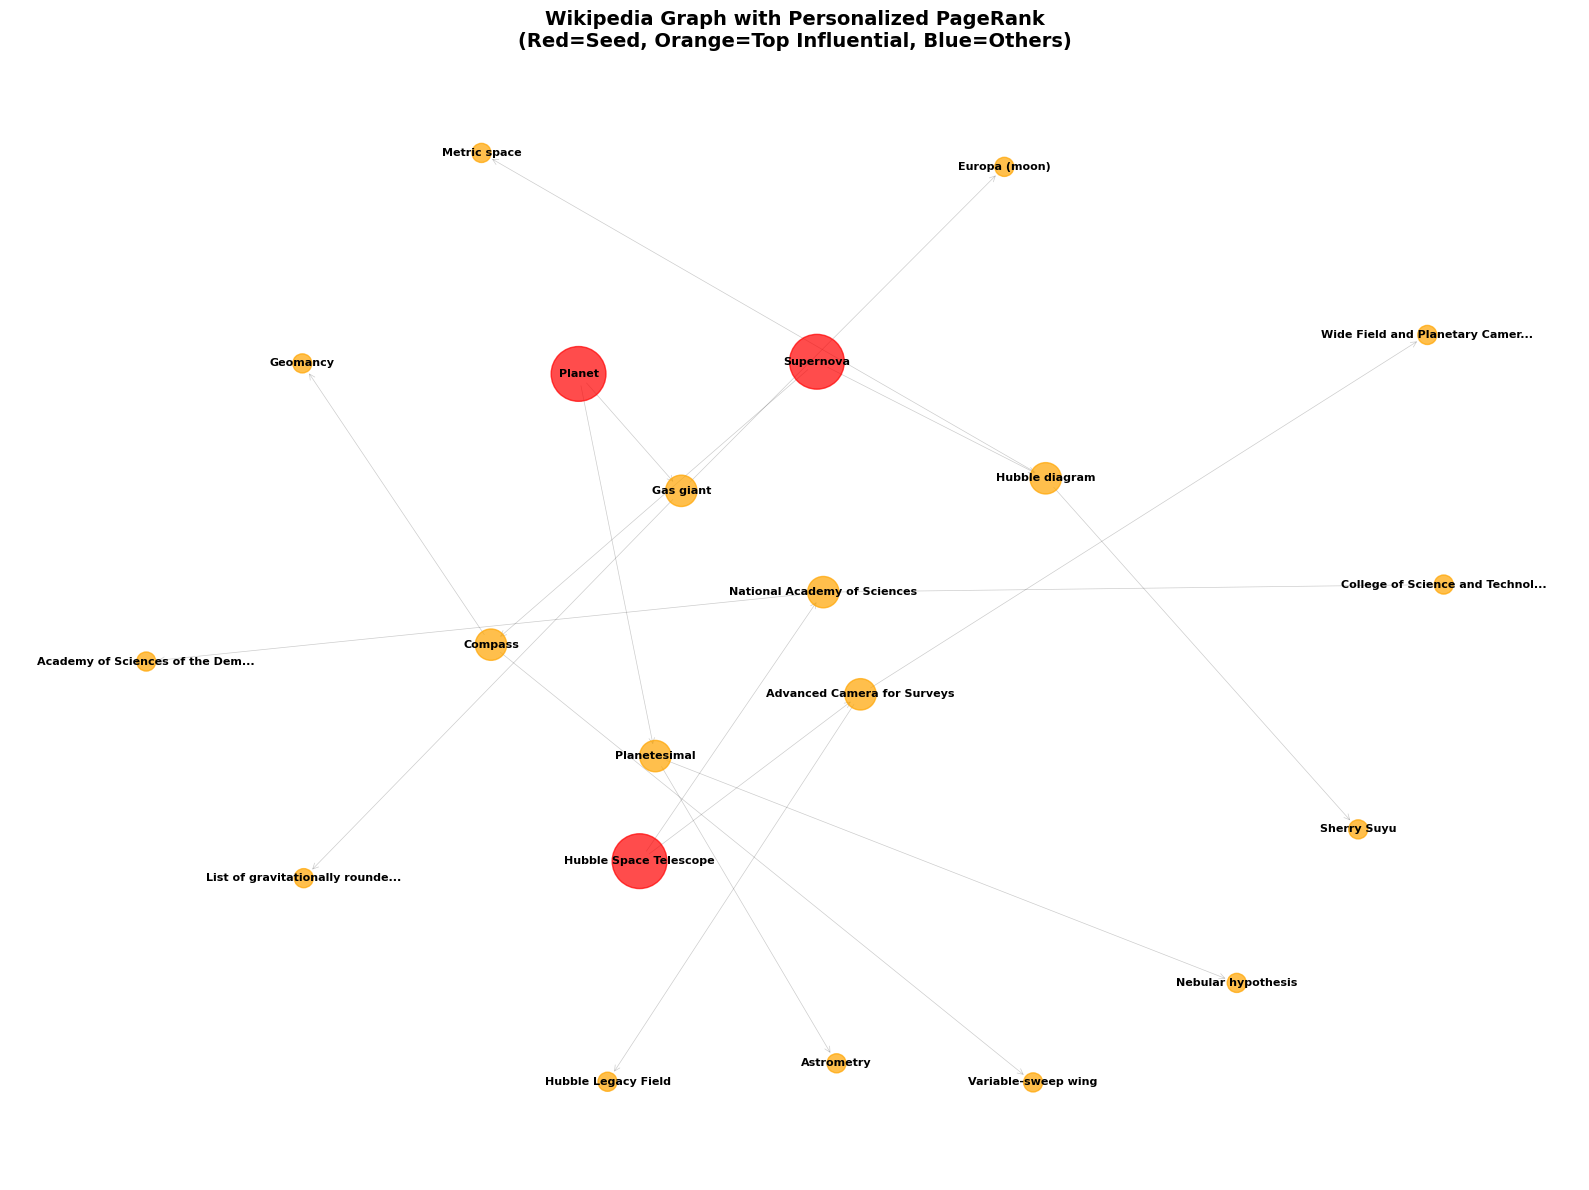


Top 30 Most Influential Pages (by Personalized PageRank):
----------------------------------------------------------------------
 1. Hubble Space Telescope                             (Score: 0.15565935)
 2. Supernova                                          (Score: 0.15565935)
 3. Planet                                             (Score: 0.15565935)
 4. National Academy of Sciences                       (Score: 0.05103404)
 5. Gas giant                                          (Score: 0.05103404)
 6. Advanced Camera for Surveys                        (Score: 0.05103404)
 7. Compass                                            (Score: 0.05103404)
 8. Planetesimal                                       (Score: 0.05103404)
 9. Hubble diagram                                     (Score: 0.05103404)
10. Hubble Legacy Field                                (Score: 0.01890148)
11. Metric space                                       (Score: 0.01890148)
12. Geomancy                                 

In [113]:
# Calculate PageRank scores
pagerank_scores = personalized_pagerank(G, seed_pages, damping=0.85)
# Visualize the graph
visualize_graph(G, pagerank_scores, seed_pages, top_n=30)

HITS

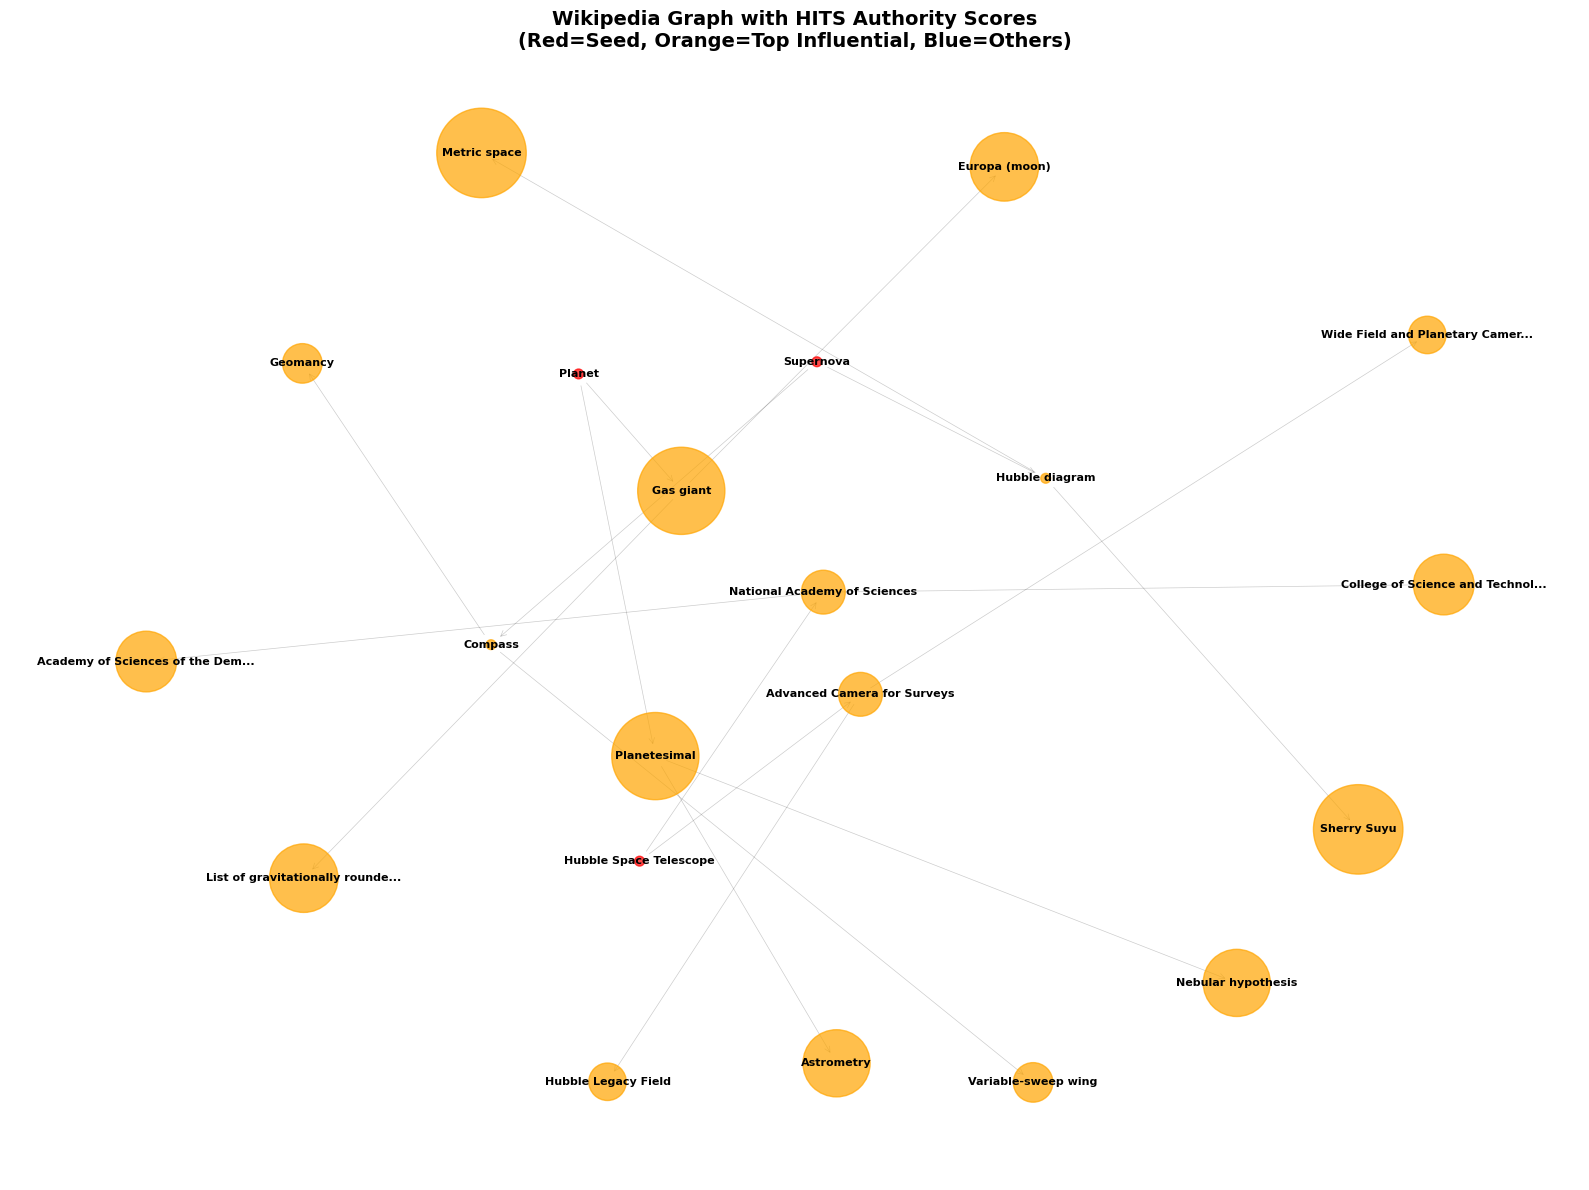

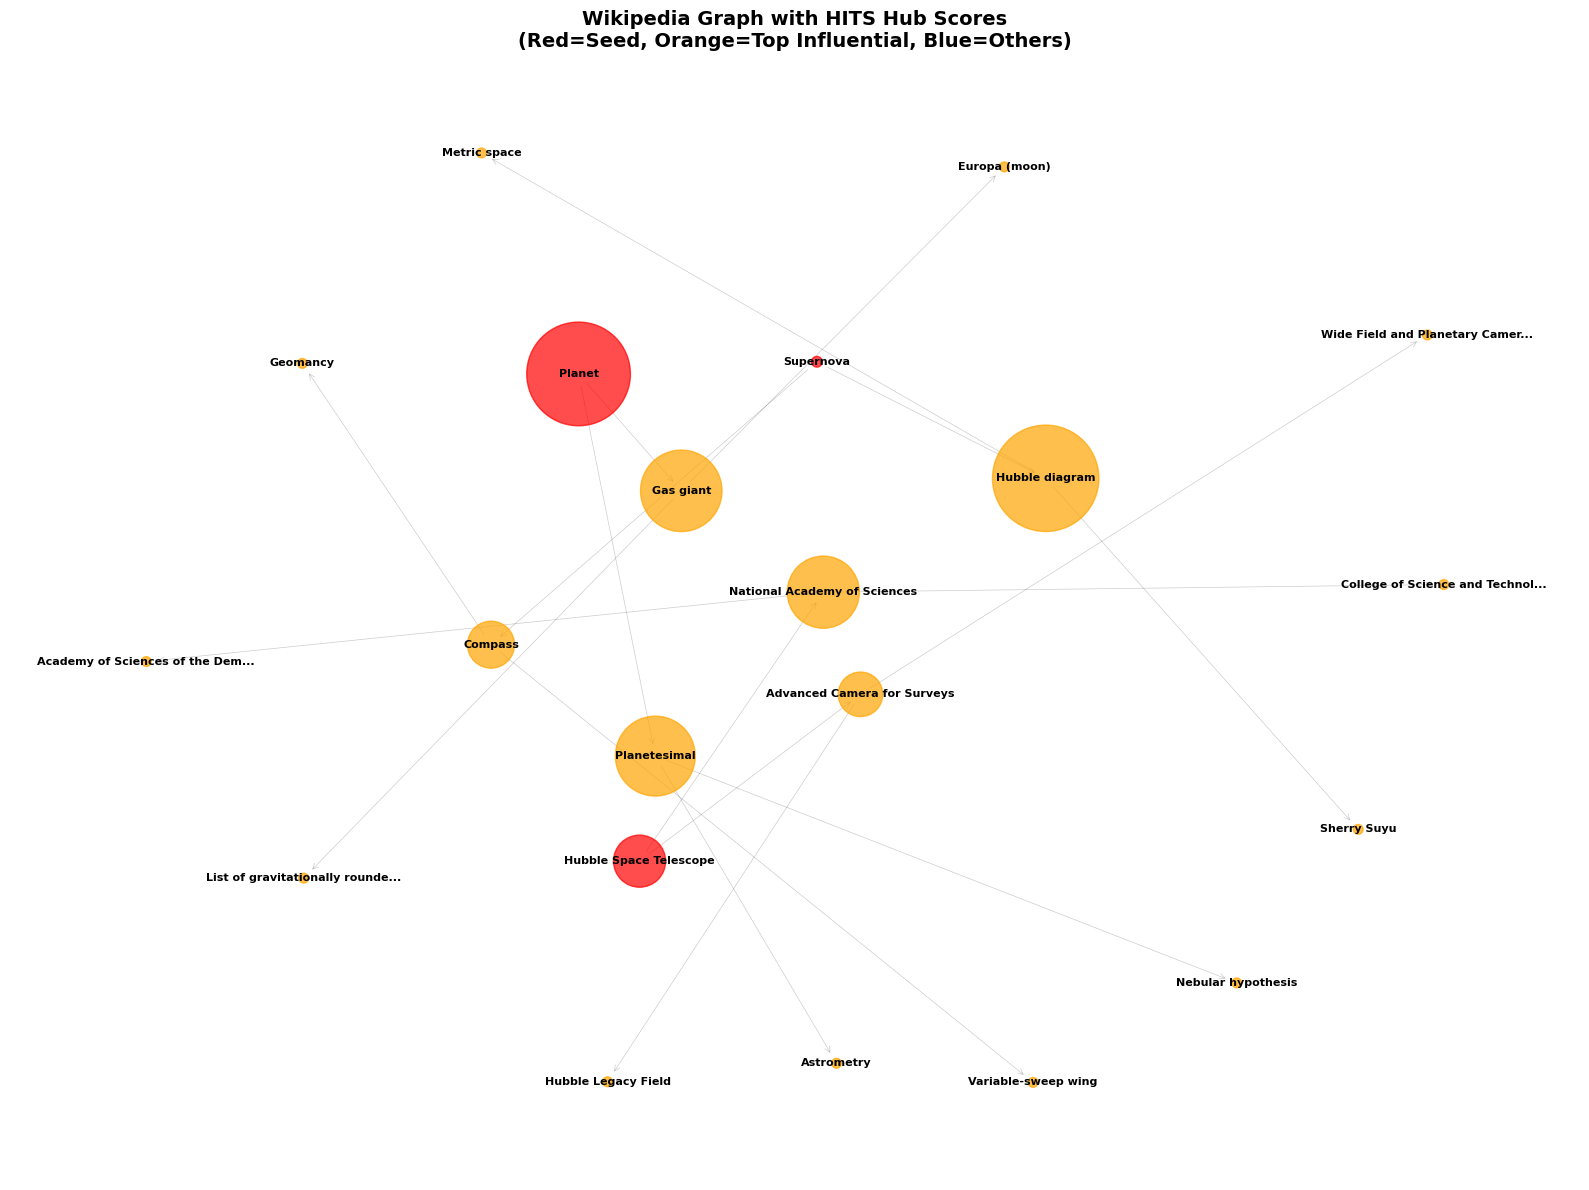


Top 30 Most Influential Pages (by HITS Authority Scores):
----------------------------------------------------------------------
 1. Metric space                                       (Score: 0.41504140)
 2. Sherry Suyu                                        (Score: 0.41504140)
 3. Gas giant                                          (Score: 0.39426374)
 4. Planetesimal                                       (Score: 0.39426374)
 5. List of gravitationally rounded objects of the Sol (Score: 0.24344164)
 6. Europa (moon)                                      (Score: 0.24344164)
 7. Astrometry                                         (Score: 0.23391403)
 8. Nebular hypothesis                                 (Score: 0.23391403)
 9. College of Science and Technology (Rwanda)         (Score: 0.19105886)
10. Academy of Sciences of the Democratic People's Rep (Score: 0.19105886)
11. National Academy of Sciences                       (Score: 0.09960599)
12. Advanced Camera for Surveys              

In [114]:
# Calculate HITS authority and hub scores
authority_scores, hub_scores = hits(G)
# Visualize the graphs
visualize_hits(G, authority_scores, hub_scores, seed_pages, top_n=30)